In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.linalg import toeplitz, solve_triangular

from Gaussian import Gaussian
from run_coverage_test import run_coverage_test, plot_coverage, plot_coverage_by_dim
from LinGaussTest import LinGaussInvProb, LinGaussTest
from helper import get_random_corr_mat
from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf

# Inverse Problem Setup

Linear Gaussian inverse problem with a forward model defined as the composition of a linear convolution with a 
sub-sampling observation operator.

In [2]:
def gaussian_kernel(x, lengthscale):
    return np.exp(-0.5 * (x / lengthscale) ** 2)

def gaussian_kernel_grid(size, lengthscale):
    """
    Evaluates discrete Gaussian kernel exp(-(i/sigma)^2 / 2) at 
    `size` integers. If `size` is odd this will result in symmetry 
    about zero, otherwise it will be off by one. e.g., for `size = 3`
    the values are evaluated at -1, 0, 1. For `size = 4` evaluated 
    at -2, -1, 0, 1. The kernel values are normalized to sum to one.
    """
    x = np.arange(size) - size // 2
    kernel = np.exp(-0.5 * (x / lengthscale) ** 2)
    kernel /= kernel.sum()
    return kernel

def gaussian_cov_mat(d, lengthscale, scale):
    Sig = np.zeros((d,d))
    for i in range(d):
        for j in range(i+1):
            k = gaussian_kernel(i-j, lengthscale)
            Sig[i,j] = k
            Sig[j,i] = k
            
    return scale**2 * Sig

def linear_same_convolution(u, k_vals):
    """
    Linear convolution of `u` with `k_vals`, returning vector of same 
    length as `u`. Discrete convolution of the "same" variety.
    """

    out = np.convolve(u, k_vals, mode="full")

    # Clip so output is of length equal to `len(u)`
    start = len(k_vals) // 2
    end = start + len(u)
    return out[start:end]

def construct_toeplitz_forward_model(d, ker_vals):
    """
    Returns linear matrix G representing the forward model. This is a 
    Toeplitz matrix encoding the discrete linear convolution.
    d is the dimension of the discretized signal u, and ker_vals
    is the vector of discrete kernel evaluations.

    Returns a (d,d) Toeplitz matrix encoding a discrete linear 
    "same" convolution.
    """

    kernel_length = len(ker_vals)

    first_col = np.zeros(d)
    first_col[:kernel_length//2+1] = ker_vals[kernel_length//2::-1]
    
    first_row = np.zeros(d)
    first_row[:kernel_length//2+1] = ker_vals[kernel_length//2:]
    
    G = toeplitz(first_col, first_row)
    return G


def construct_noise_cov(G, variances):
    # Compose covariance matrix in singular basis
    U, s, Vh = np.linalg.svd(G)
    C_eps = (Vh.T * variances) @ Vh

    return C_eps
    

In [3]:
rng = np.random.default_rng(532124)

d = 100
ker_length = 21
ker_lengthscale = 20
grid = np.arange(d)

# Prior distribution
jitter = 1e-8
m0 = np.zeros(d)
C0 = gaussian_cov_mat(d, lengthscale=5, scale=1) + jitter * np.identity(d)

# Forward model (convolution with sampling)
s = 4 # every sth spatial index is observed
ker_grid = gaussian_kernel_grid(ker_length, ker_lengthscale)
G_conv = construct_toeplitz_forward_model(d, ker_grid)

idx_obs = np.arange(0, d, s)
n = len(idx_obs)
H = np.zeros((n, d), dtype=int)
H[np.arange(n), idx_obs] = 1
G = H @ G_conv

# Noise covariance
variances = np.sqrt(0.2)**2 * np.ones(n)
Sig = np.diag(variances)

In [4]:
# Inverse problem object
inv_prob = LinGaussInvProb(rng, G, m0, C0, Sig)

g_conv_true = G_conv @ inv_prob.u_true

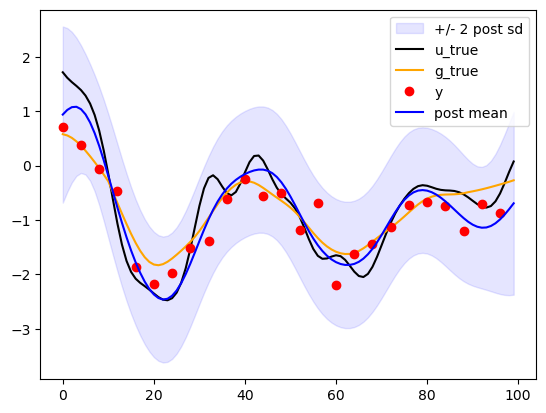

In [5]:
post_sd = np.sqrt(np.diag(inv_prob.post.cov))
ci_lower = inv_prob.post.mean - 2 * post_sd
ci_upper = inv_prob.post.mean + 2 * post_sd

plt.fill_between(grid, ci_lower, ci_upper, color='blue', alpha=0.1, label="+/- 2 post sd")
plt.plot(grid, inv_prob.u_true, color="black", label="u_true")
plt.plot(grid, g_conv_true, color="orange", label="g_true")
plt.plot(idx_obs, inv_prob.y, "o", color="red", label="y")
plt.plot(grid, inv_prob.post.mean, color="blue", label="post mean")
plt.legend()
plt.show()

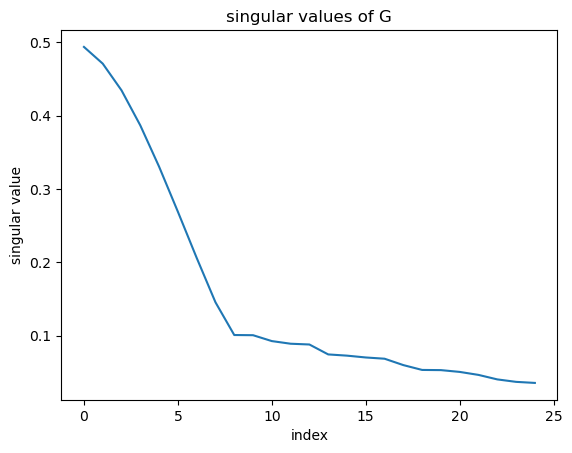

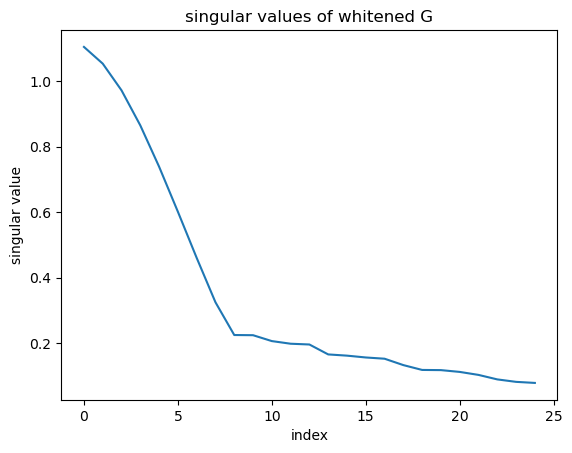

In [6]:
svd_fig = inv_prob.plot_G_singular_vals()
whitened_svd_fig = inv_prob.plot_G_singular_vals(whiten=True)

display(svd_fig)
display(whitened_svd_fig)

In [53]:
def lambda_exact(s, c0=1., sig=1.):
    """
    s, sig2 can be flat arrays of potentially different length
    """
    s = np.asarray(s)
    sig2 = np.asarray(sig) ** 2
    c02 = c0 ** 2
    c02_s = c02 * s

    if sig2.ndim == 0:
        sig2 = sig2.reshape(1)
    if c02_s.ndim == 0:
        c02_s = c02_s.reshape(1)

    denom = 1. + c02_s[np.newaxis] / sig2[:,np.newaxis] # (nsig, ns)
    return c02 / denom


def lambda_eup(s, q, c0=1., sig=1.):
    """
    s, q can be flat arrays of potentially different length 
    """
    return lambda_exact(s, c0=c0, sig=np.sqrt(sig**2 + q**2))


def lambda_ep(s, q, c0=1., sig=1.):
    """
    s, q can be flat arrays of potentially different length 
    """
    eig_exact = lambda_exact(s, c0=c0, sig=sig)

    q2 = np.asarray(q) ** 2
    s2 = np.asarray(s) ** 2
    sig4 = np.asarray(sig) ** 4
    c04 = c0 ** 4

    if s2.ndim == 0:
        s2 = s2.reshape(1)
    if q2.ndim == 0:
        q2 = q2.reshape(1)

    q2_s2 = s2[np.newaxis] * q2[:,np.newaxis] # (nq, ns)
    inflation = q2_s2 * c04 / sig4

    return eig_exact + inflation



In [54]:
c0 = 1.0
sig = 1.0

U, s, Vh = np.linalg.svd(G)
q_vals = np.linspace(0, 15, num=100)

eig_exact = lambda_exact(s, c0=c0, sig=sig)
eig_eup = lambda_eup(s, q_vals, c0=c0, sig=sig)
eig_ep = lambda_ep(s, q_vals, c0=c0, sig=sig)

eig_eup_norm = eig_eup / eig_exact
eig_ep_norm = eig_ep / eig_exact

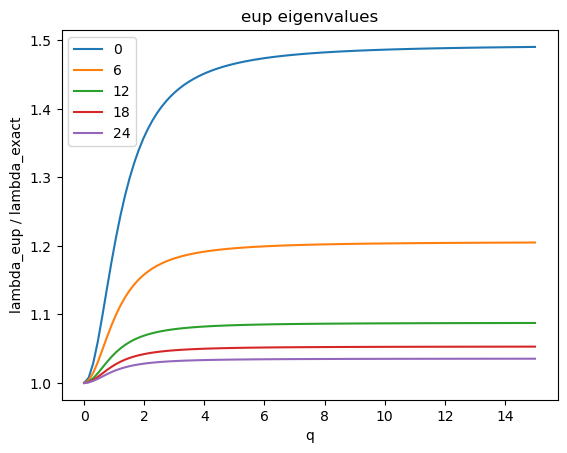

In [ ]:
idcs = np.arange(0, 25, 6).astype(int)
labels = [str(idx) for idx in idcs]

fig, ax = plt.subplots(2, 1, figsize=(8,4))

eup_eig_plot = ax.plot(q_vals, eig_eup_norm[:,idcs])
ax.set_title('eup eigenvalues')
ax.set_xlabel('q')
ax.set_ylabel('lambda_eup / lambda_exact')
ax.legend(eup_eig_plot, labels)


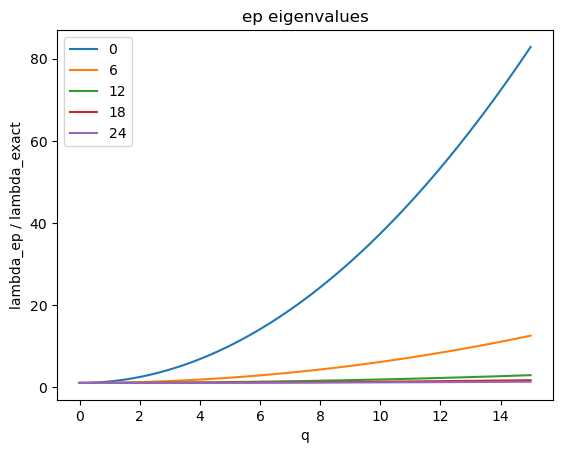

In [55]:
idcs = np.arange(0, 25, 6).astype(int)
labels = [str(idx) for idx in idcs]

fig, ax = plt.subplots()

ep_eig_plot = ax.plot(q_vals, eig_ep_norm[:,idcs])
ax.set_title('ep eigenvalues')
ax.set_xlabel('q')
ax.set_ylabel('lambda_ep / lambda_exact')
ax.legend(ep_eig_plot, labels)

# Surrogate Model

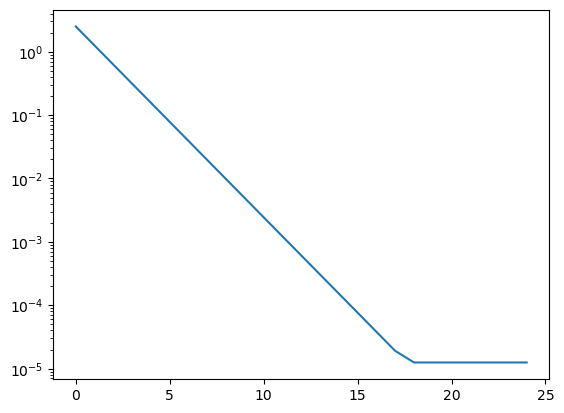

In [7]:
# Construct Q so that trace(Q) = trace(Sig) (doubling total noise)
tr_Sig = np.trace(inv_prob.noise.cov)
q_floor = 1e-6
q_start = np.max(np.diag(inv_prob.noise.cov))
q = np.array([max(q_floor, q_start/2**i) for i in range(n)])
q_vars = tr_Sig * q / q.sum()

plt.semilogy(q_vars)
plt.show()

In [167]:
U, s, Vh = np.linalg.svd(inv_prob.G)

# High noise in stable directions
Q_stable = (U*q_vars) @ U.T

# High noise in unstable directions
Q_unstable = (U*q_vars[::-1]) @ U.T

# Noise proportional to prior pushforward
Q_prior = 0.5 * G @ inv_prob.prior.cov @ G.T

# All error in first left singular vector direction
idx = 0
u1 = U[idx,:]
eps = 1e-6
scaler = np.sum(s)
Q1 = 5 * scaler * np.linalg.outer(u1, u1) + eps * np.identity(inv_prob.n)

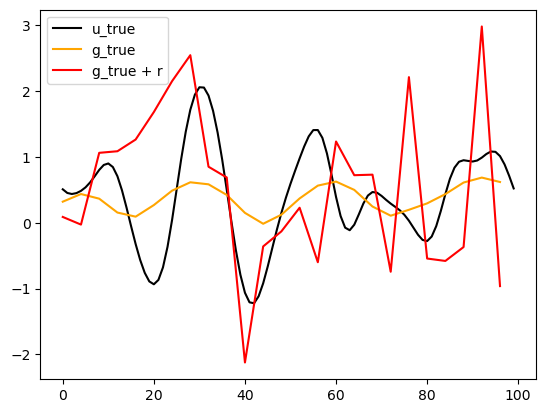

In [171]:
u_samp = inv_prob.prior.sample()
g_samp = inv_prob.G @ u_samp

r_samp = Gaussian(rng=rng, cov=Q1).sample()
g_samp_perturbed = g_samp + r_samp

plt.plot(grid, u_samp, color="black", label="u_true")
plt.plot(idx_obs, g_samp, color="orange", label="g_true")
plt.plot(idx_obs, g_samp_perturbed, color="red", label="g_true + r")
plt.legend()
plt.show()

# Run Numerical Experiments

In [9]:
n_reps = 100
n_plot_rows = int(max(1, np.ceil(d/4)))

In [172]:
inv_prob_rep, test_rep, res, probs = run_coverage_test(rng, n_reps, m0=inv_prob.prior.mean, 
                                                       C0=inv_prob.prior.cov, Sig=inv_prob.noise.cov, 
                                                       G=inv_prob.G, Q_true=Q1, Q=Q1)

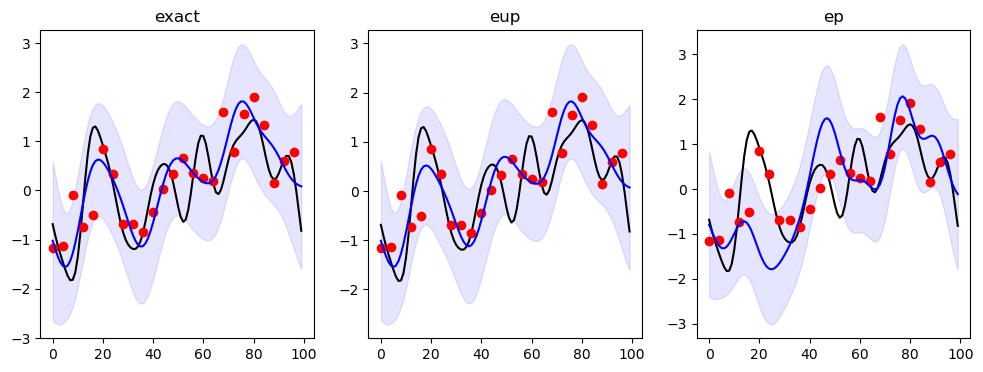

In [173]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

# Exact 
post_sd = np.sqrt(np.diag(inv_prob_rep.post.cov))
ci_lower = inv_prob_rep.post.mean - 2 * post_sd
ci_upper = inv_prob_rep.post.mean + 2 * post_sd

ax[0].fill_between(grid, ci_lower, ci_upper, color='blue', alpha=0.1, label="+/- 2 post sd")
ax[0].plot(grid, inv_prob_rep.u_true, color="black", label="u_true")
ax[0].plot(idx_obs, inv_prob_rep.y, "o", color="red", label="y")
ax[0].plot(grid, inv_prob_rep.post.mean, color="blue", label="post mean")
ax[0].set_title("exact")
# ax[0].legend()

# EUP 
post_sd_eup = np.sqrt(np.diag(test_rep.eup_post.cov))
ci_lower_eup = test_rep.eup_post.mean - 2 * post_sd_eup
ci_upper_eup = test_rep.eup_post.mean + 2 * post_sd_eup

ax[1].fill_between(grid, ci_lower_eup, ci_upper_eup, color='blue', alpha=0.1, label="+/- 2 post sd")
ax[1].plot(grid, inv_prob_rep.u_true, color="black", label="u_true")
ax[1].plot(idx_obs, inv_prob_rep.y, "o", color="red", label="y")
ax[1].plot(grid, test_rep.eup_post.mean, color="blue", label="post mean")
ax[1].set_title("eup")

# EP 
post_sd_ep = np.sqrt(np.diag(test_rep.ep_post.cov))
ci_lower_ep = test_rep.ep_post.mean - 2 * post_sd_eup
ci_upper_ep = test_rep.ep_post.mean + 2 * post_sd_eup

ax[2].fill_between(grid, ci_lower_ep, ci_upper_ep, color='blue', alpha=0.1, label="+/- 2 post sd")
ax[2].plot(grid, inv_prob_rep.u_true, color="black", label="u_true")
ax[2].plot(idx_obs, inv_prob_rep.y, "o", color="red", label="y")
ax[2].plot(grid, test_rep.ep_post.mean, color="blue", label="post mean")
ax[2].set_title("ep")

plt.show()

In [ ]:
# tester.estimate_expected_kl(100000)
# tester.calc_expected_kl()

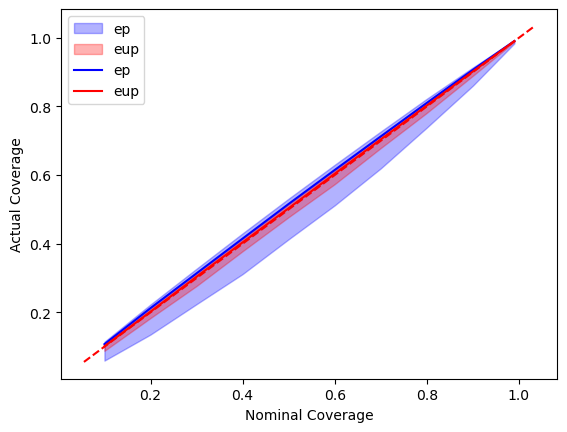

In [175]:
fig_joint_cover, ax_joint_cover = plot_coverage(res["ep_cover_joint"], res["eup_cover_joint"], probs=probs)
display(fig_joint_cover)

In [ ]:
fig = plot_coverage_by_dim(res["ep_cover_univariate"], res["eup_cover_univariate"], 
                           probs, q_min=0.1, q_max=0.9, nrows=n_plot_rows)

display(fig)

In [ ]:
n_bins = 30

fig_kl, ax_kl = plt.subplots()
ax_kl.hist(res["ep_kl"], bins=n_bins, label="ep")
ax_kl.hist(res["eup_kl"], bins=n_bins, label="eup", alpha=0.5)
ax_kl.legend()

plt.show()

In [ ]:
n_bins = 30

fig_ekl, ax_ekl = plt.subplots()
ax_ekl.hist(res["ep_expected_kl"], bins=n_bins, label="ep")
ax_ekl.hist(res["eup_expected_kl"], bins=n_bins, label="eup", alpha=0.5)
ax_ekl.legend()

plt.show()

In [ ]:
# Exact inverse problem.
inv_prob = LinGaussInvProb(rng, d, n, C0_scale=1.0, Sig_scale=1.0)
plt_inv_prob = inv_prob.plot_marginals()
display(plt_inv_prob)

In [ ]:
# Surrogate-based inverse problem.
Q = Q_scale**2 * get_random_corr_mat(n, rng)
test = LinGaussTest(inv_prob, Q)

In [ ]:
fig_coverage = test.plot_coverage()
display(fig_coverage)

In [ ]:
n_samp = 50000
fig_hist = test.get_hist_plot(n_samp)
display(fig_hist)

In [ ]:
tester = test.calc_coverage()

In [ ]:
tester["ep"].shape

In [ ]:
for k in tester.keys():
    print(k)

In [ ]:
test.reset_samplers()
fig_rk = test.get_hist_plot(n_samp, include=["ep", "eup", "rk", "rk-pcn"])
display(fig_rk)

In [ ]:
cov_scalers = [0.1, 0.5, 0.9]
figs = []
for s in cov_scalers:
    test.reset_samplers()
    test.samplers["rk-pcn"].kernels[0].proposal.cov = s * test.prior.cov
    fig = test.get_hist_plot(n_samp, include=["ep", "rk-pcn"])
    figs.append(fig)
    display(fig)